In [2]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import scipy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import random

In [3]:
import layers as custom_layers

In [4]:
# We renamed cusolver64_11.dll to cusolver64_10.dll to solve the compatibility issue.
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
# File Paths
imgIdxCsvPath = './MRNet/MRNet-v1.0/similar.csv'
MRI_Path = './MRNet/MRNet-v1.0/train/axial/{}.npy'

## Load self-generated training data (by data loaders)

### Duplicate fixed image as labels

In [6]:
trainDataPath = "./affineTrainingData/affine{}.npz"
trainDataSize = 2000
fixedImg = np.load(MRI_Path.format("0701"))
fixedImg = fixedImg / np.max(fixedImg)
fixedImg = fixedImg.astype('float32')
fixedImg = np.expand_dims(fixedImg, axis=-1)

def data_generator(batch_size = 5):
    # TODO: Batchify the funciton.
    while True:
        imgPair_batch = np.zeros((batch_size, *fixedImg.shape[:-1], 2)).astype('float32')
        fixedImg_batch = np.zeros((batch_size, *fixedImg.shape)).astype('float32')
        tgtAffineTrf_batch = np.zeros((batch_size, 12)).astype('float32')
        for i in range(batch_size):
            idx = random.randrange(trainDataSize)
            inputObj = np.load(trainDataPath.format(idx))
            movingImg = inputObj['img']
            movingImg = np.expand_dims(movingImg, axis=-1)
            movingImg = movingImg.astype('float32')
            imgPair = np.concatenate([movingImg, fixedImg], axis=3)
            imgPair_batch[i] = imgPair

            tgtAffineTrf = inputObj['trf']
            tgtAffineTrf = tgtAffineTrf.astype('float32')
            tgtAffineTrf_batch[i] = tgtAffineTrf
            fixedImg_batch[i] = fixedImg
        
        yield (imgPair_batch, [fixedImg_batch, tgtAffineTrf_batch])

## NN with labels as fixed images

In [7]:
leaky_relu_alpha = 0.3
def res_block(x, filters, kernel_size=(3, 3, 3), strides=(1, 1, 1)):
    x_skip = x
    f1, f2 = filters
    
    if f1 == f2:
        x = layers.Conv3D(filters=f1, kernel_size=kernel_size, strides=(1, 1, 1),
                          padding="same", kernel_regularizer=keras.regularizers.L2(l2=0.001))(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=leaky_relu_alpha)(x)
        
        x = layers.Conv3D(filters=f2, kernel_size=kernel_size, strides=(1, 1, 1),
                          padding="same", kernel_regularizer=keras.regularizers.L2(l2=0.001))(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Add()([x, x_skip])
        x = layers.LeakyReLU(alpha=leaky_relu_alpha)(x)
        return x
    
    else:
        x = layers.Conv3D(filters=f1, kernel_size=kernel_size, strides=(1, 1, 1),
                          padding="same", kernel_regularizer=keras.regularizers.L2(l2=0.001))(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=leaky_relu_alpha)(x)
        
        x = layers.Conv3D(filters=f2, kernel_size=kernel_size, strides=strides,
                          padding="valid", kernel_regularizer=keras.regularizers.L2(l2=0.001))(x)
        x = layers.BatchNormalization()(x)
        
        x_skip = layers.Conv3D(filters=f2, kernel_size=kernel_size, strides=strides,
                               padding="valid", kernel_regularizer=keras.regularizers.L2(l2=0.001))(x_skip)
        
        x = layers.Add()([x, x_skip])
        x = layers.LeakyReLU(alpha=leaky_relu_alpha)(x)
        return x
    

In [8]:
inputs = keras.Input(shape = (*fixedImg.shape[:-1], 2))
moving_input = tf.expand_dims(inputs[:, :, :, :, 0], axis = -1)
# fixed_input = tf.expand_dims(inputs[:, :, :, :, 1], axis = -1)

# down_depths = [4, 8, 16, 24, 32]
# up_depths = [2, 16, 32, 16, 3]

x = layers.Conv3D(filters=32, kernel_size=(7, 15, 15), strides=(2, 2, 2), activation="relu")(inputs) # relu or leaky_relu?
x = layers.MaxPool3D((1, 2, 2))(x)
print("0: {}".format(x.shape))

# First stage, no dimesnion changes
x = res_block(x, kernel_size=(3, 9, 9), filters=(32, 32))
x = res_block(x, kernel_size=(3, 9, 9), filters=(32, 32))
x = res_block(x, kernel_size=(3, 9, 9), filters=(32, 32))
print("1: {}".format(x.shape))

# Second stage, increase channel depth, halve the height and width
x = res_block(x, kernel_size=(3, 9, 9), filters=(32, 64), strides=(1, 2, 2))
x = res_block(x, filters=(64, 64))
x = res_block(x, filters=(64, 64))
x = res_block(x, filters=(64, 64))
print("2: {}".format(x.shape))

# Third stage
x = res_block(x, filters=(64, 128), strides=(2, 2, 2))
x = res_block(x, filters=(128, 128))
x = res_block(x, filters=(128, 128))
x = res_block(x, filters=(128, 128))
print("3: {}".format(x.shape))

# Fourth stage
x = res_block(x, filters=(128, 256), strides=(2, 2, 2))
x = res_block(x, filters=(256, 256))
x = res_block(x, filters=(256, 256))
x = res_block(x, filters=(256, 256))
print("4: {}".format(x.shape))

# f_conv_0 = layers.Conv3D(filters=down_depths[0], kernel_size=(6, 32, 32), strides=(1, 2, 2), activation="relu")(fixed_input)
# f_conv_0 = layers.BatchNormalization()(f_conv_0)
# f_conv_1 = layers.Conv3D(filters=down_depths[1], kernel_size=(6, 16, 16), strides=(2, 2, 2), activation="relu")(f_conv_0)
# f_conv_1 = layers.BatchNormalization()(f_conv_1)
# # f_filtered_conv_1 = layers.MaxPool3D((2, 2, 2))(f_conv_1)
# f_conv_2 = layers.Conv3D(filters=down_depths[2], kernel_size=(6, 8, 8), activation="relu")(f_conv_1)
# f_conv_2 = layers.BatchNormalization()(f_conv_2)
# # f_filtered_conv_2 = layers.MaxPool3D((1, 2, 2))(f_conv_2)
# f_conv_3 = layers.Conv3D(filters=down_depths[3], kernel_size=(4, 8, 8), strides=(1, 2, 2), activation="relu")(f_conv_2)
# f_conv_3 = layers.BatchNormalization()(f_conv_3)
# f_conv_4 = layers.Conv3D(filters=down_depths[4], kernel_size=(4, 4, 4), activation="relu")(f_conv_3)
# f_conv_4 = layers.BatchNormalization()(f_conv_4)

# concat_feats = tf.concat([conv_4, f_conv_4], axis = -1)
# print(concat_feats.shape)

x = layers.AveragePooling3D((2, 2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dense(512)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
affine_pred = layers.Dense(12, activation="linear", name="affine_pred")(x)

# convTransposed_3 = layers.Conv3DTranspose(filters=up_depths[0], kernel_size=(6, 10, 10), activation="relu")(conv_4)
# print("convTransposed_3: {}".format(convTransposed_3.shape))
# filtered_convTransposed_2 = layers.Conv3DTranspose(filters=up_depths[1], kernel_size=(6, 20, 20), activation="relu")(convTransposed_3)
# print("filtered_convTransposed_2: {}".format(filtered_convTransposed_2.shape))
# convTransposed_2 = layers.UpSampling3D((1, 2, 2))(filtered_convTransposed_2)
# print("convTransposed_2: {}".format(convTransposed_2.shape))
# filtered_convTransposed_1 = layers.Conv3DTranspose(filters=up_depths[2], kernel_size=(3, 15, 15), activation="relu")(convTransposed_2)
# print("filtered_convTransposed_1: {}".format(filtered_convTransposed_1.shape))
# convTransposed_1 = layers.UpSampling3D((2, 2, 2))(filtered_convTransposed_1)
# print("convTransposed_1: {}".format(convTransposed_1.shape))
# convTransposed_0 = layers.Conv3DTranspose(filters=up_depths[3], kernel_size=(3, 16, 16), activation="relu")(convTransposed_1)
# print("convTransposed_0: {}".format(convTransposed_0.shape))
# deformation_field_pred = layers.Conv3DTranspose(filters=up_depths[4], kernel_size=(3, 10, 10), activation="relu")(convTransposed_0)
# print("deformation_field_pred: {}".format(deformation_field_pred.shape))

affine_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=True)([moving_input, affine_pred])
# deformable_warped = custom_layers.SpatialTransformer(interp_method='linear', add_identity=False, name="warped_image", shift_center=False)([affine_warped, deformation_field_pred])
print(affine_warped.shape)

0: (None, 23, 60, 60, 32)
1: (None, 23, 60, 60, 32)
2: (None, 21, 26, 26, 64)
3: (None, 10, 12, 12, 128)
4: (None, 4, 5, 5, 256)
Instructions for updating:
Use fn_output_signature instead
(None, 52, 256, 256, 1)


In [8]:
model = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred], name="combined_model")
model.summary()

Model: "combined_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 52, 256, 256 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 23, 121, 121, 100832      input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling3d (MaxPooling3D)    (None, 23, 60, 60, 3 0           conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 23, 60, 60, 3 248864      max_pooling3d[0][0]              
_____________________________________________________________________________________

In [ ]:
dataGen = data_generator(batch_size = 1)
moving_test, label_test = next(dataGen)
print(moving_test.shape)
(warped_test, affine_pred_test) = model(moving_test)
print(label_test[1])
print(label_test[1].dtype)
print(affine_pred_test)
mse = tf.keras.losses.MeanSquaredError()
print(mse(label_test[1], affine_pred_test))

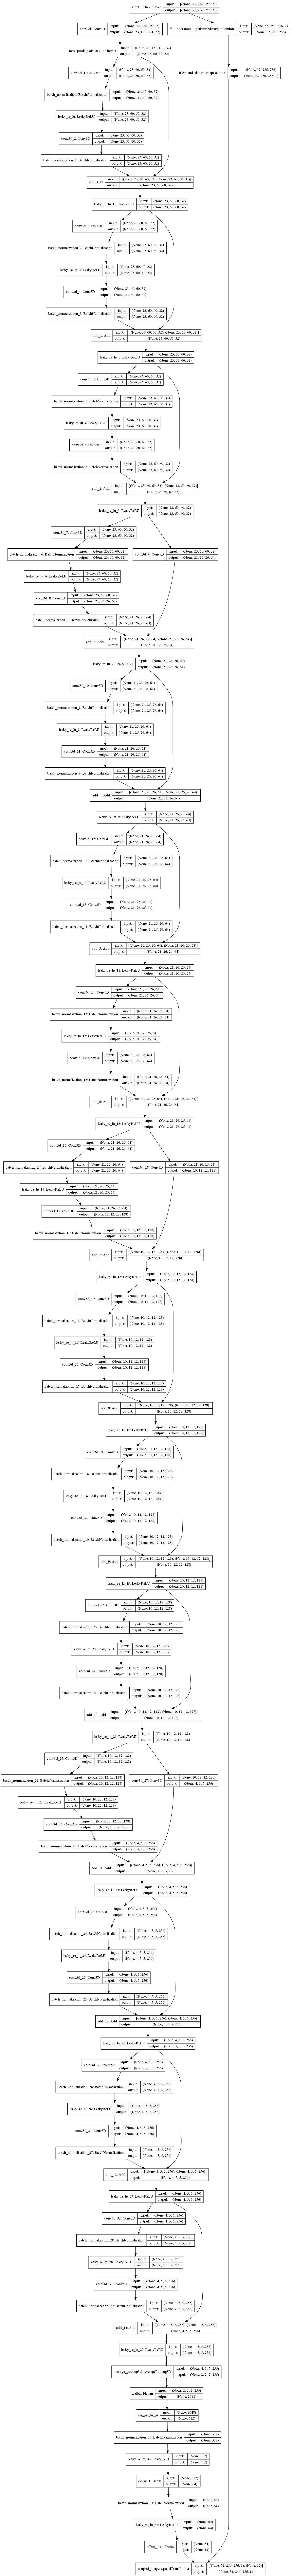

In [9]:
keras.utils.plot_model(model, "test.png", show_shapes=True)

In [10]:
lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
# loss_object = tf.keras.losses.MeanSquaredError()

loss_history = []
save_callback = ModelCheckpoint('./checkpoints/{epoch:02d}.h5')

In [ ]:
"""
y = (deformed_img, affine_trf)
"""
def affine_loss(y_actual, y_pred):
    y_actual = y_actual[0]
    y_pred = y_pred[0]
    tgtDiag = [y_actual[0]] + [y_actual[5]] + [y_actual[10]]
    predDiag = [y_pred[0]] + [y_pred[5]] + [y_pred[10]]
    tgtCorner = y_actual[1:3] + [y_actual[4]] + [y_actual[6]] + y_actual[8:10]
    predCorner = y_pred[1:3] + [y_pred[4]] + [y_pred[6]] + y_pred[8:10]
    tgtTranslation = [y_actual[3]] + [y_actual[7]] + [y_actual[11]]
    predTranslation = [y_pred[3]] + [y_pred[7]] + [y_pred[11]]
    mse = tf.keras.losses.MeanSquaredError()
    diag_loss = mse(tgtDiag, predDiag)
    corner_loss = mse(tgtCorner, predCorner)
    translation_loss = mse(tgtTranslation, predTranslation)
    return corner_loss * 10 + diag_loss * 10 + translation_loss

In [11]:
model.compile(optimizer=optimizer,
              loss={"warped_image":"mean_squared_error", "affine_pred":"mean_squared_error"},
#               loss_weights={"warped_image":1, "affine_pred":1},
              run_eagerly=True)

In [12]:
dataGen = data_generator(batch_size=4)

In [13]:
model.fit(dataGen, epochs=30, steps_per_epoch=tr ainDataSize/4, callbacks=[save_callback])

Epoch 1/30
500/500 [==============================] - 732s 1s/step - loss: 33.0338 - warped_image_loss: 0.0806 - affine_pred_loss: 28.8271
Epoch 2/30
500/500 [==============================] - 697s 1s/step - loss: 7.6397 - warped_image_loss: 0.0621 - affine_pred_loss: 4.5230
Epoch 3/30
500/500 [==============================] - 697s 1s/step - loss: 6.3748 - warped_image_loss: 0.0578 - affine_pred_loss: 4.3298
Epoch 4/30
500/500 [==============================] - 696s 1s/step - loss: 5.5291 - warped_image_loss: 0.0548 - affine_pred_loss: 4.2242
Epoch 5/30
500/500 [==============================] - 696s 1s/step - loss: 4.9766 - warped_image_loss: 0.0511 - affine_pred_loss: 4.1400
Epoch 6/30
500/500 [==============================] - 695s 1s/step - loss: 4.6588 - warped_image_loss: 0.0467 - affine_pred_loss: 4.1081
Epoch 7/30
500/500 [==============================] - 695s 1s/step - loss: 4.3410 - warped_image_loss: 0.0445 - affine_pred_loss: 3.9654
Epoch 8/30
500/500 [===================

## Test model (output == warpedImg)

In [9]:
testModel = keras.Model(inputs=inputs, outputs=[affine_warped, affine_pred])

In [10]:
# testModel.load_weights('./checkpoints/epoch_{}'.format(epochs-1))
testModel.load_weights('./checkpoints/19.h5')

In [11]:
dataGen_test = data_generator(batch_size = 5)
moving_test, label_test = next(dataGen_test)
(warped_test, affine_pred_test) = testModel(moving_test)
print(label_test[1])
print(affine_pred_test)
mse = tf.keras.losses.MeanSquaredError()
print(mse(label_test[1], affine_pred_test))

[[ 1.0141639e+00  4.1618306e-02  4.0183317e-02 -1.8444717e+00
  -3.7898287e-02  9.8608607e-01 -6.4807080e-02 -1.0765969e+01
  -4.5490116e-02  6.9009148e-02  1.0766256e+00 -5.5288644e+00]
 [ 1.1201813e+00  3.6104273e-02  3.1796213e-02 -3.1572409e+00
  -2.9691635e-02  1.0328031e+00 -1.2670036e-01 -1.9511972e+01
  -3.0291513e-02  1.1414542e-01  9.3755966e-01 -2.0324772e+01]
 [ 8.9279956e-01  3.6187191e-02  2.1562114e-02 -3.0069714e+00
  -3.7357196e-02  9.6117282e-01 -6.6303968e-02 -1.1445001e+01
  -2.3360433e-02  5.8986980e-02  8.6826420e-01 -7.6056695e+00]
 [ 9.0116704e-01  4.6371467e-02  1.8120196e-02 -5.0268273e+00
  -5.2250519e-02  1.0393317e+00 -6.1196409e-02 -1.7825836e+01
  -2.0850567e-02  5.2150223e-02  9.0349805e-01 -1.0456270e+01]
 [ 9.3477333e-01  2.3204802e-02  2.0998728e-02 -2.1274266e+00
  -1.6109856e-02  9.5068979e-01 -3.3342513e-01  1.3948750e+00
  -2.5583614e-02  2.8754765e-01  8.2111615e-01 -2.6006001e+01]]
tf.Tensor(
[[ 9.4673753e-01  1.2338936e-02  4.2608865e-02 -3.007

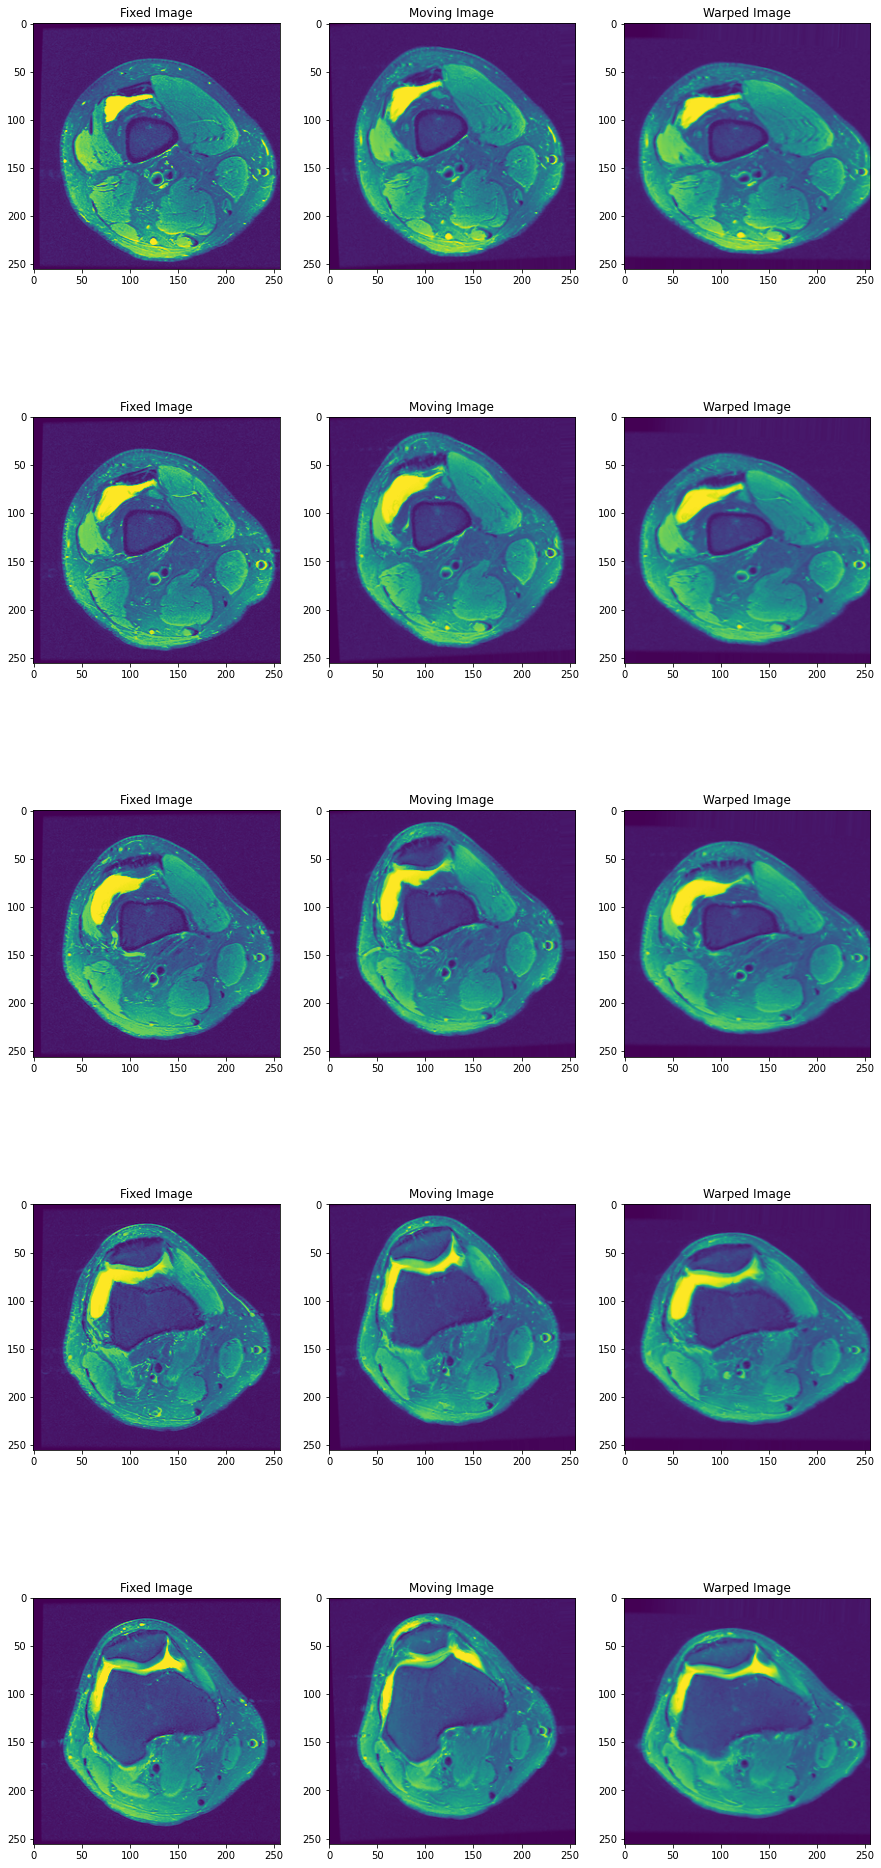

In [22]:
sliceToCheck = 0
fig, axs = plt.subplots(5, 3, figsize=(15, 35))
for i in range(5):
    axs[i, 0].imshow(fixedImg[sliceToCheck + i * 5,:,:,0])
    axs[i, 0].set_title("Fixed Image")
    axs[i, 1].imshow(moving_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 1].set_title("Moving Image")
    axs[i, 2].imshow(warped_test[0,sliceToCheck + i * 5,:,:,0])
    axs[i, 2].set_title("Warped Image")
plt.show()